In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torchvision import models, utils
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
batch_size = 8
num_epoch = 10
# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint7'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log7'

In [4]:
# 생성한 train_data 폴더에 있는 이미지들을 텐서로 변환하여 불러옴
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root='D:/torchtorch/data/train_data', transform=trans)

In [5]:
# load 데이터 정보 확인
train_data

Dataset ImageFolder
    Number of datapoints: 933
    Root location: D:/torchtorch/data/train_data
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
data_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True)

# 1배치에 들어갈 데이터 
# 1epoch = 933 = 8batch
# 1batch = 933/8(batch_size) = 117
num_data = len(data_loader.dataset)
num_batch = np.ceil(num_data / batch_size)
print(num_data)
print(num_batch)

933
117.0


torch.Size([8, 3, 64, 128])
torch.Size([8])
tensor([0, 4, 1, 1, 3, 2, 3, 1])


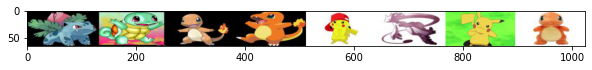

In [7]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(8개 이미지 존재)
dataiter = iter(data_loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 8개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [8]:
class Pokemon_CNN(nn.Module):
    def __init__(self):
        super(Pokemon_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 6, kernel_size = 5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features = 16*13*29, out_features = 120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = 120,out_features = 5, bias=True)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.layer3(out)
        return out

In [9]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = Pokemon_CNN().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)

writer = SummaryWriter(log_dir=log_dir)

In [10]:
from torchsummary import summary
print(summary(net, (3,64,128)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6, 60, 124]             456
              ReLU-2           [-1, 6, 60, 124]               0
         MaxPool2d-3            [-1, 6, 30, 62]               0
            Conv2d-4           [-1, 16, 26, 58]           2,416
              ReLU-5           [-1, 16, 26, 58]               0
         MaxPool2d-6           [-1, 16, 13, 29]               0
            Linear-7                  [-1, 120]         723,960
              ReLU-8                  [-1, 120]               0
            Linear-9                    [-1, 5]             605
Total params: 727,437
Trainable params: 727,437
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 1.18
Params size (MB): 2.77
Estimated Total Size (MB): 4.05
-------------------------------------------

In [11]:
## 트레이닝 시작하기
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()

    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(data_loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = net(input)
        # output shape = (batch, 8)
#         print(output.shape)
        
        # pred shape = (batch, 8)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))
    
    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)

    save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)

writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0117 | LOSS: 1.5919 | ACC 0.2500
TRAIN: EPOCH 0001/0010 | BATCH 0002/0117 | LOSS: 1.5794 | ACC 0.2500
TRAIN: EPOCH 0001/0010 | BATCH 0003/0117 | LOSS: 1.6595 | ACC 0.2083
TRAIN: EPOCH 0001/0010 | BATCH 0004/0117 | LOSS: 1.6332 | ACC 0.2812
TRAIN: EPOCH 0001/0010 | BATCH 0005/0117 | LOSS: 1.6364 | ACC 0.2750
TRAIN: EPOCH 0001/0010 | BATCH 0006/0117 | LOSS: 1.6681 | ACC 0.2500
TRAIN: EPOCH 0001/0010 | BATCH 0007/0117 | LOSS: 1.6660 | ACC 0.2679
TRAIN: EPOCH 0001/0010 | BATCH 0008/0117 | LOSS: 1.6472 | ACC 0.2656
TRAIN: EPOCH 0001/0010 | BATCH 0009/0117 | LOSS: 1.6403 | ACC 0.2639
TRAIN: EPOCH 0001/0010 | BATCH 0010/0117 | LOSS: 1.6400 | ACC 0.2500
TRAIN: EPOCH 0001/0010 | BATCH 0011/0117 | LOSS: 1.6373 | ACC 0.2500
TRAIN: EPOCH 0001/0010 | BATCH 0012/0117 | LOSS: 1.6409 | ACC 0.2292
TRAIN: EPOCH 0001/0010 | BATCH 0013/0117 | LOSS: 1.6391 | ACC 0.2308
TRAIN: EPOCH 0001/0010 | BATCH 0014/0117 | LOSS: 1.6351 | ACC 0.2411
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0002/0010 | BATCH 0012/0117 | LOSS: 0.7117 | ACC 0.7292
TRAIN: EPOCH 0002/0010 | BATCH 0013/0117 | LOSS: 0.6917 | ACC 0.7308
TRAIN: EPOCH 0002/0010 | BATCH 0014/0117 | LOSS: 0.7136 | ACC 0.7232
TRAIN: EPOCH 0002/0010 | BATCH 0015/0117 | LOSS: 0.7522 | ACC 0.7167
TRAIN: EPOCH 0002/0010 | BATCH 0016/0117 | LOSS: 0.7348 | ACC 0.7188
TRAIN: EPOCH 0002/0010 | BATCH 0017/0117 | LOSS: 0.7110 | ACC 0.7353
TRAIN: EPOCH 0002/0010 | BATCH 0018/0117 | LOSS: 0.7225 | ACC 0.7222
TRAIN: EPOCH 0002/0010 | BATCH 0019/0117 | LOSS: 0.7346 | ACC 0.7237
TRAIN: EPOCH 0002/0010 | BATCH 0020/0117 | LOSS: 0.7843 | ACC 0.7188
TRAIN: EPOCH 0002/0010 | BATCH 0021/0117 | LOSS: 0.7695 | ACC 0.7202
TRAIN: EPOCH 0002/0010 | BATCH 0022/0117 | LOSS: 0.7492 | ACC 0.7273
TRAIN: EPOCH 0002/0010 | BATCH 0023/0117 | LOSS: 0.7354 | ACC 0.7337
TRAIN: EPOCH 0002/0010 | BATCH 0024/0117 | LOSS: 0.7280 | ACC 0.7344
TRAIN: EPOCH 0002/0010 | BATCH 0025/0117 | LOSS: 0.7183 | ACC 0.7450
TRAIN: EPOCH 0002/0010 | BATCH 002

TRAIN: EPOCH 0003/0010 | BATCH 0031/0117 | LOSS: 0.5698 | ACC 0.8065
TRAIN: EPOCH 0003/0010 | BATCH 0032/0117 | LOSS: 0.5719 | ACC 0.8008
TRAIN: EPOCH 0003/0010 | BATCH 0033/0117 | LOSS: 0.5636 | ACC 0.8068
TRAIN: EPOCH 0003/0010 | BATCH 0034/0117 | LOSS: 0.5573 | ACC 0.8088
TRAIN: EPOCH 0003/0010 | BATCH 0035/0117 | LOSS: 0.5526 | ACC 0.8107
TRAIN: EPOCH 0003/0010 | BATCH 0036/0117 | LOSS: 0.5534 | ACC 0.8056
TRAIN: EPOCH 0003/0010 | BATCH 0037/0117 | LOSS: 0.5468 | ACC 0.8074
TRAIN: EPOCH 0003/0010 | BATCH 0038/0117 | LOSS: 0.5409 | ACC 0.8125
TRAIN: EPOCH 0003/0010 | BATCH 0039/0117 | LOSS: 0.5388 | ACC 0.8109
TRAIN: EPOCH 0003/0010 | BATCH 0040/0117 | LOSS: 0.5325 | ACC 0.8125
TRAIN: EPOCH 0003/0010 | BATCH 0041/0117 | LOSS: 0.5343 | ACC 0.8140
TRAIN: EPOCH 0003/0010 | BATCH 0042/0117 | LOSS: 0.5261 | ACC 0.8155
TRAIN: EPOCH 0003/0010 | BATCH 0043/0117 | LOSS: 0.5185 | ACC 0.8169
TRAIN: EPOCH 0003/0010 | BATCH 0044/0117 | LOSS: 0.5111 | ACC 0.8210
TRAIN: EPOCH 0003/0010 | BATCH 004

TRAIN: EPOCH 0004/0010 | BATCH 0050/0117 | LOSS: 0.4153 | ACC 0.8550
TRAIN: EPOCH 0004/0010 | BATCH 0051/0117 | LOSS: 0.4124 | ACC 0.8554
TRAIN: EPOCH 0004/0010 | BATCH 0052/0117 | LOSS: 0.4076 | ACC 0.8582
TRAIN: EPOCH 0004/0010 | BATCH 0053/0117 | LOSS: 0.4013 | ACC 0.8608
TRAIN: EPOCH 0004/0010 | BATCH 0054/0117 | LOSS: 0.3945 | ACC 0.8634
TRAIN: EPOCH 0004/0010 | BATCH 0055/0117 | LOSS: 0.3890 | ACC 0.8659
TRAIN: EPOCH 0004/0010 | BATCH 0056/0117 | LOSS: 0.3860 | ACC 0.8683
TRAIN: EPOCH 0004/0010 | BATCH 0057/0117 | LOSS: 0.3801 | ACC 0.8706
TRAIN: EPOCH 0004/0010 | BATCH 0058/0117 | LOSS: 0.3762 | ACC 0.8707
TRAIN: EPOCH 0004/0010 | BATCH 0059/0117 | LOSS: 0.3731 | ACC 0.8729
TRAIN: EPOCH 0004/0010 | BATCH 0060/0117 | LOSS: 0.3712 | ACC 0.8729
TRAIN: EPOCH 0004/0010 | BATCH 0061/0117 | LOSS: 0.3685 | ACC 0.8750
TRAIN: EPOCH 0004/0010 | BATCH 0062/0117 | LOSS: 0.3665 | ACC 0.8750
TRAIN: EPOCH 0004/0010 | BATCH 0063/0117 | LOSS: 0.3638 | ACC 0.8750
TRAIN: EPOCH 0004/0010 | BATCH 006

TRAIN: EPOCH 0005/0010 | BATCH 0051/0117 | LOSS: 0.2472 | ACC 0.9191
TRAIN: EPOCH 0005/0010 | BATCH 0052/0117 | LOSS: 0.2449 | ACC 0.9207
TRAIN: EPOCH 0005/0010 | BATCH 0053/0117 | LOSS: 0.2435 | ACC 0.9198
TRAIN: EPOCH 0005/0010 | BATCH 0054/0117 | LOSS: 0.2436 | ACC 0.9190
TRAIN: EPOCH 0005/0010 | BATCH 0055/0117 | LOSS: 0.2459 | ACC 0.9182
TRAIN: EPOCH 0005/0010 | BATCH 0056/0117 | LOSS: 0.2492 | ACC 0.9152
TRAIN: EPOCH 0005/0010 | BATCH 0057/0117 | LOSS: 0.2459 | ACC 0.9167
TRAIN: EPOCH 0005/0010 | BATCH 0058/0117 | LOSS: 0.2485 | ACC 0.9159
TRAIN: EPOCH 0005/0010 | BATCH 0059/0117 | LOSS: 0.2468 | ACC 0.9174
TRAIN: EPOCH 0005/0010 | BATCH 0060/0117 | LOSS: 0.2461 | ACC 0.9167
TRAIN: EPOCH 0005/0010 | BATCH 0061/0117 | LOSS: 0.2435 | ACC 0.9180
TRAIN: EPOCH 0005/0010 | BATCH 0062/0117 | LOSS: 0.2405 | ACC 0.9194
TRAIN: EPOCH 0005/0010 | BATCH 0063/0117 | LOSS: 0.2415 | ACC 0.9187
TRAIN: EPOCH 0005/0010 | BATCH 0064/0117 | LOSS: 0.2396 | ACC 0.9180
TRAIN: EPOCH 0005/0010 | BATCH 006

TRAIN: EPOCH 0006/0010 | BATCH 0071/0117 | LOSS: 0.2372 | ACC 0.9190
TRAIN: EPOCH 0006/0010 | BATCH 0072/0117 | LOSS: 0.2349 | ACC 0.9201
TRAIN: EPOCH 0006/0010 | BATCH 0073/0117 | LOSS: 0.2366 | ACC 0.9178
TRAIN: EPOCH 0006/0010 | BATCH 0074/0117 | LOSS: 0.2387 | ACC 0.9172
TRAIN: EPOCH 0006/0010 | BATCH 0075/0117 | LOSS: 0.2421 | ACC 0.9167
TRAIN: EPOCH 0006/0010 | BATCH 0076/0117 | LOSS: 0.2422 | ACC 0.9161
TRAIN: EPOCH 0006/0010 | BATCH 0077/0117 | LOSS: 0.2396 | ACC 0.9172
TRAIN: EPOCH 0006/0010 | BATCH 0078/0117 | LOSS: 0.2371 | ACC 0.9183
TRAIN: EPOCH 0006/0010 | BATCH 0079/0117 | LOSS: 0.2344 | ACC 0.9193
TRAIN: EPOCH 0006/0010 | BATCH 0080/0117 | LOSS: 0.2340 | ACC 0.9187
TRAIN: EPOCH 0006/0010 | BATCH 0081/0117 | LOSS: 0.2315 | ACC 0.9198
TRAIN: EPOCH 0006/0010 | BATCH 0082/0117 | LOSS: 0.2296 | ACC 0.9207
TRAIN: EPOCH 0006/0010 | BATCH 0083/0117 | LOSS: 0.2304 | ACC 0.9202
TRAIN: EPOCH 0006/0010 | BATCH 0084/0117 | LOSS: 0.2289 | ACC 0.9211
TRAIN: EPOCH 0006/0010 | BATCH 008

TRAIN: EPOCH 0007/0010 | BATCH 0090/0117 | LOSS: 0.1407 | ACC 0.9486
TRAIN: EPOCH 0007/0010 | BATCH 0091/0117 | LOSS: 0.1409 | ACC 0.9478
TRAIN: EPOCH 0007/0010 | BATCH 0092/0117 | LOSS: 0.1395 | ACC 0.9484
TRAIN: EPOCH 0007/0010 | BATCH 0093/0117 | LOSS: 0.1407 | ACC 0.9476
TRAIN: EPOCH 0007/0010 | BATCH 0094/0117 | LOSS: 0.1449 | ACC 0.9468
TRAIN: EPOCH 0007/0010 | BATCH 0095/0117 | LOSS: 0.1435 | ACC 0.9474
TRAIN: EPOCH 0007/0010 | BATCH 0096/0117 | LOSS: 0.1421 | ACC 0.9479
TRAIN: EPOCH 0007/0010 | BATCH 0097/0117 | LOSS: 0.1418 | ACC 0.9485
TRAIN: EPOCH 0007/0010 | BATCH 0098/0117 | LOSS: 0.1403 | ACC 0.9490
TRAIN: EPOCH 0007/0010 | BATCH 0099/0117 | LOSS: 0.1395 | ACC 0.9495
TRAIN: EPOCH 0007/0010 | BATCH 0100/0117 | LOSS: 0.1423 | ACC 0.9487
TRAIN: EPOCH 0007/0010 | BATCH 0101/0117 | LOSS: 0.1483 | ACC 0.9480
TRAIN: EPOCH 0007/0010 | BATCH 0102/0117 | LOSS: 0.1521 | ACC 0.9461
TRAIN: EPOCH 0007/0010 | BATCH 0103/0117 | LOSS: 0.1509 | ACC 0.9466
TRAIN: EPOCH 0007/0010 | BATCH 010

TRAIN: EPOCH 0008/0010 | BATCH 0111/0117 | LOSS: 0.1201 | ACC 0.9572
TRAIN: EPOCH 0008/0010 | BATCH 0112/0117 | LOSS: 0.1191 | ACC 0.9576
TRAIN: EPOCH 0008/0010 | BATCH 0113/0117 | LOSS: 0.1184 | ACC 0.9580
TRAIN: EPOCH 0008/0010 | BATCH 0114/0117 | LOSS: 0.1173 | ACC 0.9583
TRAIN: EPOCH 0008/0010 | BATCH 0115/0117 | LOSS: 0.1165 | ACC 0.9587
TRAIN: EPOCH 0008/0010 | BATCH 0116/0117 | LOSS: 0.1174 | ACC 0.9580
TRAIN: EPOCH 0008/0010 | BATCH 0117/0117 | LOSS: 0.1170 | ACC 0.9583
TRAIN: EPOCH 0009/0010 | BATCH 0001/0117 | LOSS: 0.2893 | ACC 0.8750
TRAIN: EPOCH 0009/0010 | BATCH 0002/0117 | LOSS: 0.1738 | ACC 0.9375
TRAIN: EPOCH 0009/0010 | BATCH 0003/0117 | LOSS: 0.1163 | ACC 0.9583
TRAIN: EPOCH 0009/0010 | BATCH 0004/0117 | LOSS: 0.1338 | ACC 0.9375
TRAIN: EPOCH 0009/0010 | BATCH 0005/0117 | LOSS: 0.1512 | ACC 0.9500
TRAIN: EPOCH 0009/0010 | BATCH 0006/0117 | LOSS: 0.1394 | ACC 0.9583
TRAIN: EPOCH 0009/0010 | BATCH 0007/0117 | LOSS: 0.1198 | ACC 0.9643
TRAIN: EPOCH 0009/0010 | BATCH 000

TRAIN: EPOCH 0010/0010 | BATCH 0011/0117 | LOSS: 0.0902 | ACC 0.9659
TRAIN: EPOCH 0010/0010 | BATCH 0012/0117 | LOSS: 0.0937 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0013/0117 | LOSS: 0.1132 | ACC 0.9519
TRAIN: EPOCH 0010/0010 | BATCH 0014/0117 | LOSS: 0.1058 | ACC 0.9554
TRAIN: EPOCH 0010/0010 | BATCH 0015/0117 | LOSS: 0.0996 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0016/0117 | LOSS: 0.0939 | ACC 0.9609
TRAIN: EPOCH 0010/0010 | BATCH 0017/0117 | LOSS: 0.0968 | ACC 0.9559
TRAIN: EPOCH 0010/0010 | BATCH 0018/0117 | LOSS: 0.0934 | ACC 0.9583
TRAIN: EPOCH 0010/0010 | BATCH 0019/0117 | LOSS: 0.0896 | ACC 0.9605
TRAIN: EPOCH 0010/0010 | BATCH 0020/0117 | LOSS: 0.0874 | ACC 0.9625
TRAIN: EPOCH 0010/0010 | BATCH 0021/0117 | LOSS: 0.0853 | ACC 0.9643
TRAIN: EPOCH 0010/0010 | BATCH 0022/0117 | LOSS: 0.0817 | ACC 0.9659
TRAIN: EPOCH 0010/0010 | BATCH 0023/0117 | LOSS: 0.0783 | ACC 0.9674
TRAIN: EPOCH 0010/0010 | BATCH 0024/0117 | LOSS: 0.0841 | ACC 0.9635
TRAIN: EPOCH 0010/0010 | BATCH 002